# Introduction to machine learning

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting figures

# drawing decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from sklearn.model_selection import train_test_split # split dataset into train and test data
# A bunch of standard machine learning models 
from sklearn import tree
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics #used to plot the ROC AUC

import tensorflow as tf # tensorflow is googles library for deep learning and other graph-processing tasks


# Input data files are available in the "../work/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import datetime
import os
print(os.listdir("../work"))

# Any results you write to the current directory are saved as output.

['predictions_2017_804.xlsx', 'Introduction to Machine Learning.ipynb', 'tf_model', '.ipynb_checkpoints', 'toy_sales.xlsx', 'Dockerfile']


# Machine Learning

*Machine learning is the art and science of making machines learn from data to give answers to questions. A good machine learning application has accurate results, generalizes well across the problem domain and limits the need for human action to a minimum.*

*Some important terms in machine learning are:*
* Model
>A model processes input data x to produce an output y. It's the core of any machine learning application
* training
>Training is the process of feeding examples of input data into a model, comparing the results with the desired behaviour and adjusting the model's internal state incrementally so that it produces more favourable output
* features and labels
> In machine mearning we try to find a method to learn from examples (X) to generate a desirable output (y) generally we try to find f(X) --> y . Now features are the elements of X, while labels are the elents of y e.g. age and income ; f((age, income)) --> sales .
* examples
> examples are instances of (X[ ,y]) that can be fed into the model for training or prediction e.g. (35, 2000) --> 42

* Supervised Learning
> In supervised learning the training-examples are labelled and we try to predict the label correctly. Examples of applications are predicting house-prices, sales or stock-values, classifying images or detecting spam-mails
* Semi-Supervised Learning
> In semi-supervised learning or reinforcement learning the examples don't have a distinct label. However we have a function or method to reward the model if it produces desirable output. examples are autonomous driving or robotics in general
* Unsupervised Learning
> In unsupervised learning the model does not receive any labels on the data. instead the goal is to somehow structure the data in a meaningful way. On example is clustering / segmentation

We'll focus on supervised learning in this introduction.

## Supervised Learning
> Supervised learning is concerned with two main tasks: classification and regression.

* Classification
> In classification we deal with discrete labels like black/white, good/bad, red/green/blue/yellow, cat/dog/bird . The models often calculate a probability or score for each class and we can use the class with the highest score as the prediction of the model.
* Regression
> In regression we try to predict a (more or less) continuous variable like price, age, time. 

The typical machine learning workflow consists of 7 steps:
1.  Gather and explore data
2. Prepare data
3. Choose a model
4. Train the model
5. Evaluate the model
6. Tune model parameters
7. Move model into production / predict


## 1. Gather and explore data

In [2]:
df = pd.read_excel('../work/toy_sales.xlsx')

In [3]:
df.head()

,customer,date,value
0,707,2015-01-01,489.0
1,707,2015-01-01,438.0
2,706,2015-01-01,509.0
3,545,2015-01-01,539.0
4,913,2015-01-02,509.0


In [4]:
df.describe()

,customer,value
count,4352.000000,4352.000000
mean,496.520680,1524.165097
std,284.561043,1234.585512
min,1.000000,0.000000
25%,251.750000,658.750000
50%,499.000000,1198.000000
75%,738.250000,1978.000000
max,1000.000000,12530.000000


## 2. Prepare data

In [5]:
T0 = datetime.date(2017, 1, 1)
df['days'] = (T0 - df['date']).dt.days
future = df[df['days']<0]
past = df[df['days']>=0]
past_group = past.groupby(by=['customer'])
x = past_group['days'].min()
x.name = 'recency'
x = pd.DataFrame(x)
x['frequency'] = past_group['days'].count()

future_group = future.groupby(by=['customer'])
y = future_group['days'].count()
y.name = 'y_frequency'
y = pd.DataFrame(y)
y['y_recency'] = future_group['days'].max()*(-1)

data=x.join(y)
data['y_recency'].fillna(value=366, inplace=True)
data['y_frequency'].fillna(value=0, inplace=True)
data['y_frequency'][data['y_frequency']>0] = 1
data.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,recency,frequency,y_frequency,y_recency
customer,,,,
1,407,1,1.0,215.0
2,43,3,0.0,366.0
3,314,2,1.0,143.0
4,158,5,0.0,366.0
5,306,4,1.0,152.0


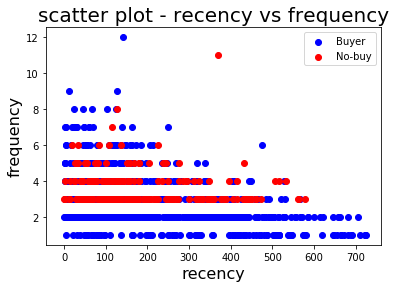

In [6]:
import matplotlib.pyplot as plt
x0, y0 = data[data['y_frequency']==0]['recency'],data[data['y_frequency']==0]['frequency']
x1, y1 = data[data['y_frequency']>0]['recency'],data[data['y_frequency']>0]['frequency']

plt.scatter(x1, y1, label='Buyer', color='b')
plt.scatter(x0, y0, label='No-buy', color='r')

plt.xlabel('recency', fontsize=16)
plt.ylabel('frequency', fontsize=16)
plt.title('scatter plot - recency vs frequency',fontsize=20)
plt.legend(loc='upper right')
plt.show()

#### Train/Test split data

In [7]:
from sklearn.model_selection import train_test_split

x = data[['recency', 'frequency']]
y_class = data['y_frequency']
y_regress = data['y_recency']

x_train, x_test, yc_train, yc_test = train_test_split(x, y_class, test_size=0.25)


## 3. Model selection

### Classification

In [8]:
def plot_roc_auc(preds, y_true):
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = metrics.roc_curve(y_true, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

In [9]:

predictions, scores = {}, {}
predictions['true_values'] = yc_test.values

classifiers = [
    {'name': 'tree', 'clf': tree.DecisionTreeClassifier()},
    {'name': 'forest', 'clf': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)},
    {'name': 'logistic', 'clf': linear_model.LogisticRegression()},
    {'name': 'kneighbors', 'clf': KNeighborsClassifier()},
    {'name': 'svc', 'clf':  SVC(gamma=2, C=1)},
    {'name': 'gaussian', 'clf': GaussianProcessClassifier(1.0 * RBF(1.0))},
    {'name': 'neural', 'clf':  MLPClassifier(solver='lbfgs', learning_rate='adaptive', max_iter=3000)},
    {'name': 'adaboost', 'clf':  AdaBoostClassifier()},
     ]

for c in classifiers:
    clf = c['clf']
    clf.fit(x_train, yc_train)
    predictions[c['name']] = clf.predict(x_test)
    scores[c['name']] = [clf.score(x_test, yc_test)]

    


In [10]:
pd.DataFrame(predictions).head()

,adaboost,forest,gaussian,kneighbors,logistic,neural,svc,tree,true_values
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [11]:
pd.DataFrame(scores).T

,0
adaboost,0.762097
forest,0.774194
gaussian,0.774194
kneighbors,0.709677
logistic,0.766129
neural,0.758065
svc,0.750000
tree,0.717742


#### Adaboost

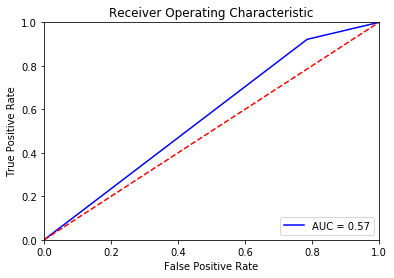

In [12]:
preds = predictions['adaboost']
y_true = predictions['true_values']
plot_roc_auc(preds, y_true)

#### Random Forest

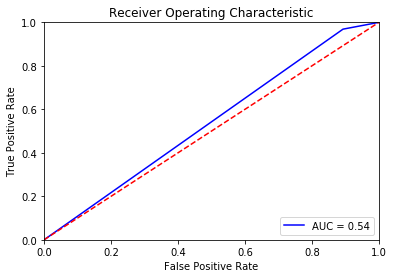

In [13]:
preds = predictions['forest']
y_true = predictions['true_values']
plot_roc_auc(preds, y_true)

#### Gaussian Process

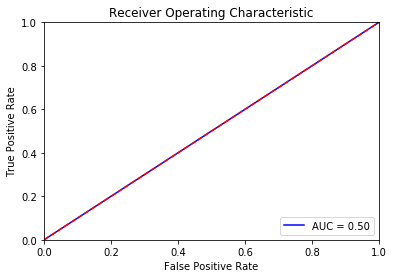

In [14]:
preds = predictions['gaussian']
y_true = predictions['true_values']
plot_roc_auc(preds, y_true)

#### K-Nearest Neighbours

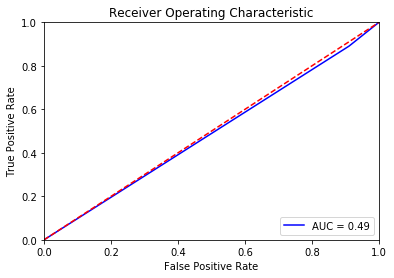

In [15]:
preds = predictions['kneighbors']
y_true = predictions['true_values']
plot_roc_auc(preds, y_true)

#### Logistic Regression

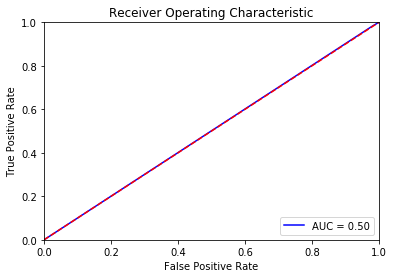

In [16]:
preds = predictions['logistic']
y_true = predictions['true_values']
plot_roc_auc(preds, y_true)

#### Multi-layer perceptron

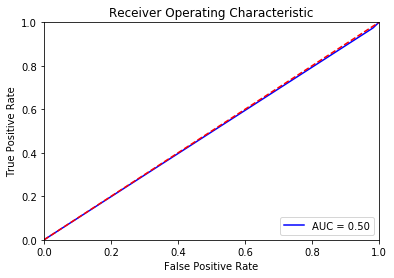

In [17]:
preds = predictions['neural']
y_true = predictions['true_values']
plot_roc_auc(preds, y_true)

#### Support Vector Classifier

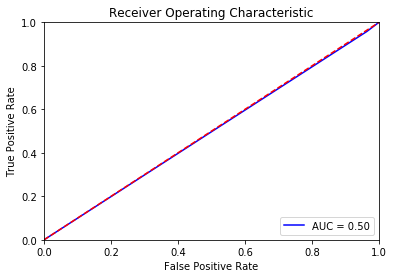

In [18]:
preds = predictions['svc']
y_true = predictions['true_values']
plot_roc_auc(preds, y_true)

#### Decision Tree

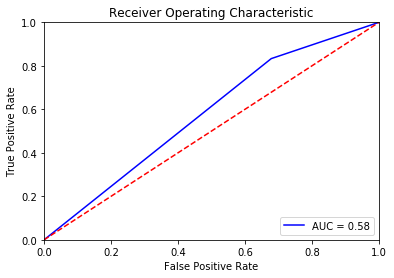

In [19]:
preds = predictions['tree']
y_true = predictions['true_values']
plot_roc_auc(preds, y_true)

### Regression

In [20]:
xr_train, xr_test, yr_train, yr_test = train_test_split(x, y_class, test_size=0.25)

In [21]:
predictions, scores = {}, {}
predictions['true_values'] = yr_test.values

regressors = [
    {'name': 'tree', 'clf': tree.DecisionTreeRegressor()},
    {'name': 'gradientboost', 'clf': GradientBoostingRegressor(n_estimators=100, learning_rate=0.5, max_depth=1, random_state=0, loss='ls')},
    {'name': 'linear', 'clf': linear_model.LinearRegression()},
    {'name': 'kneighbors', 'clf': KNeighborsRegressor()},
    {'name': 'svr', 'clf':  SVR()},
    {'name': 'gaussian', 'clf': GaussianProcessRegressor(1.0 * RBF(1.0))},
    {'name': 'neural', 'clf':  MLPRegressor(alpha=1, max_iter=1000)},
    {'name': 'adaboost', 'clf':  AdaBoostRegressor()},
     ]

for r in regressors:
    clf = r['clf']
    clf.fit(xr_train, yr_train)
    predictions[r['name']] = clf.predict(xr_test)
    scores[r['name']] = [clf.score(xr_test, yr_test)]

In [22]:
pd.DataFrame(predictions).head().T

,0,1,2,3,4
adaboost,1.000000,5.572917e-01,1.000000,0.761468,1.000000
gaussian,0.487924,7.697982e-148,1.000000,-0.001523,1.000000
gradientboost,0.963597,6.045191e-01,0.977819,0.795032,0.977497
kneighbors,0.600000,8.000000e-01,0.800000,0.600000,1.000000
linear,0.840072,7.923201e-01,0.921777,0.519738,0.861983
neural,0.515180,1.131642e+00,3.765912,0.560937,2.982590
svr,0.831137,5.479128e-01,0.900017,0.779158,0.899724
tree,1.000000,0.000000e+00,1.000000,0.000000,1.000000
true_values,1.000000,1.000000e+00,1.000000,1.000000,1.000000


In [23]:
pd.DataFrame(scores).T

,0
adaboost,0.234506
gaussian,-1.124414
gradientboost,0.221171
kneighbors,-0.224988
linear,0.034786
neural,-9.966374
svr,-0.310401
tree,-0.656842


## Neuronal Networks

* <http://neuralnetworksanddeeplearning.com/>

### Perceptron

![perceptron](http://neuralnetworksanddeeplearning.com/images/tikz0.png)

1. `output = activation( w1*x1 + w2*x2 + w3*x3 + b)`
1. ` foreach(example):`
  1. `loss = (true_value - output)`
  1. `w1 = w1 + (learning_rate * loss * x1)`
  1. `w2 = w2 + (learning_rate * loss * x2)`
  1. `w3 = w3 + (learning_rate * loss * x3)`

### Activations

#### Linear
![linear](https://cdn-images-1.medium.com/max/1600/1*tldIgyDQWqm-sMwP7m3Bww.png)

#### Sigmoid
![sigmoid](https://ml4a.github.io/images/figures/sigmoid.png)

#### RelU
![relu](https://ml4a.github.io/images/figures/relu.png)

### Multi-Layer-Perceptron
![mlp](http://neuralnetworksanddeeplearning.com/images/tikz1.png)

##  Deep Learning and Tensorflow

* <http://playground.tensorflow.org>

In [24]:
def build_model_columns(cols):
    """Builds a set of wide and deep feature columns."""
    assert isinstance(cols, pd.Index)
    feats = list()
    for c in cols:
        feats.append(tf.feature_column.numeric_column(c))

    # return wide_columns, deep_columns, weight_column
    return feats, feats


In [25]:
def input_fn(features, labels, num_epochs, shuffle, batch_size):
    """Generate an input function for the Estimator."""

    # Convert the inputs to a Dataset.
    ds = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    if shuffle:
        ds = ds.shuffle(1000)

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    ds = ds.repeat(num_epochs)
    ds = ds.batch(batch_size)
    return ds

In [26]:
def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset

In [27]:
def build_estimator(cols):
    """Build an estimator appropriate for the given model type."""
    wide_columns, deep_columns = build_model_columns(cols)

    #hidden_units = [100, 75, 50, 25]
    a = len(wide_columns) #365
    hidden_units = [5, 3, 2]

    # Create a tf.estimator.RunConfig to ensure the model is run on CPU, which
    # trains faster than GPU for this model.
    run_config = tf.estimator.RunConfig().replace(session_config=tf.ConfigProto())

    return tf.estimator.DNNLinearCombinedClassifier(
        model_dir='../work/tf_model/',
        linear_feature_columns=wide_columns,
        dnn_feature_columns=deep_columns,
        dnn_hidden_units=hidden_units,
        config=run_config,
        dnn_optimizer=tf.train.AdamOptimizer()
    )

In [28]:
clf = build_estimator(x_train.columns)

INFO:tensorflow:Using config: {'_model_dir': '../work/tf_model/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': , '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f85c3e6d438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [29]:
clf.train(input_fn=lambda: input_fn(x_train.reset_index().drop('customer', axis=1), yc_train, num_epochs=100, shuffle=True, batch_size=3))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../work/tf_model/model.ckpt-24767
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 24768 into ../work/tf_model/model.ckpt.
INFO:tensorflow:loss = 0.81010973, step = 24768
INFO:tensorflow:global_step/sec: 845.399
INFO:tensorflow:loss = 1.8280398, step = 24868 (0.121 sec)
INFO:tensorflow:global_step/sec: 1615.81
INFO:tensorflow:loss = 1.9486759, step = 24968 (0.062 sec)
INFO:tensorflow:global_step/sec: 1597.7
INFO:tensorflow:loss = 2.0057576, step = 25068 (0.063 sec)
INFO:tensorflow:global_step/sec: 1598.67
INFO:tensorflow:loss = 2.289481, step = 25168 (0.062 sec)
INFO:tensorflow:global_step/sec: 1600.9
INFO:tensorflow:loss = 0.8026135, step = 25268 (0.063 sec)
INFO:tensorflow:global_step/sec: 1613.65
INFO:tensorflow:loss =

INFO:tensorflow:global_step/sec: 1630.33
INFO:tensorflow:loss = 0.84570813, step = 32668 (0.062 sec)
INFO:tensorflow:global_step/sec: 1604.97
INFO:tensorflow:loss = 0.5478512, step = 32768 (0.062 sec)
INFO:tensorflow:global_step/sec: 1621.01
INFO:tensorflow:loss = 1.9647647, step = 32868 (0.062 sec)
INFO:tensorflow:global_step/sec: 1604.89
INFO:tensorflow:loss = 1.0127444, step = 32968 (0.062 sec)
INFO:tensorflow:global_step/sec: 1617.89
INFO:tensorflow:loss = 1.8990334, step = 33068 (0.062 sec)
INFO:tensorflow:global_step/sec: 1602.29
INFO:tensorflow:loss = 1.6955547, step = 33168 (0.063 sec)
INFO:tensorflow:global_step/sec: 1586.26
INFO:tensorflow:loss = 1.7592926, step = 33268 (0.063 sec)
INFO:tensorflow:global_step/sec: 1591.83
INFO:tensorflow:loss = 0.58560115, step = 33368 (0.063 sec)
INFO:tensorflow:global_step/sec: 1587.14
INFO:tensorflow:loss = 0.7988404, step = 33468 (0.063 sec)
INFO:tensorflow:global_step/sec: 1601.01
INFO:tensorflow:loss = 0.61957836, step = 33568 (0.062 se

INFO:tensorflow:global_step/sec: 1619.31
INFO:tensorflow:loss = 2.7877321, step = 40868 (0.062 sec)
INFO:tensorflow:global_step/sec: 1625.65
INFO:tensorflow:loss = 0.4958448, step = 40968 (0.061 sec)
INFO:tensorflow:global_step/sec: 1610.73
INFO:tensorflow:loss = 1.9919188, step = 41068 (0.062 sec)
INFO:tensorflow:global_step/sec: 1607.2
INFO:tensorflow:loss = 0.7231939, step = 41168 (0.062 sec)
INFO:tensorflow:global_step/sec: 1621.05
INFO:tensorflow:loss = 0.8006284, step = 41268 (0.062 sec)
INFO:tensorflow:global_step/sec: 1573.05
INFO:tensorflow:loss = 0.9679041, step = 41368 (0.064 sec)
INFO:tensorflow:global_step/sec: 1550.51
INFO:tensorflow:loss = 0.651544, step = 41468 (0.065 sec)
INFO:tensorflow:global_step/sec: 1568.84
INFO:tensorflow:loss = 0.4358261, step = 41568 (0.064 sec)
INFO:tensorflow:global_step/sec: 1577.85
INFO:tensorflow:loss = 0.6412845, step = 41668 (0.063 sec)
INFO:tensorflow:global_step/sec: 1613.32
INFO:tensorflow:loss = 1.7641463, step = 41768 (0.062 sec)
IN

INFO:tensorflow:global_step/sec: 1623.07
INFO:tensorflow:loss = 0.7594193, step = 49068 (0.062 sec)
INFO:tensorflow:global_step/sec: 1617.36
INFO:tensorflow:loss = 1.750082, step = 49168 (0.062 sec)
INFO:tensorflow:global_step/sec: 1626.54
INFO:tensorflow:loss = 2.0667531, step = 49268 (0.062 sec)
INFO:tensorflow:global_step/sec: 1570.15
INFO:tensorflow:loss = 3.2280693, step = 49368 (0.064 sec)
INFO:tensorflow:global_step/sec: 1599.37
INFO:tensorflow:loss = 2.6777718, step = 49468 (0.063 sec)
INFO:tensorflow:Saving checkpoints for 49534 into ../work/tf_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.38640112.


In [30]:
predictions = list(clf.predict(input_fn=lambda: eval_input_fn(x_test, labels=None, batch_size=1)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../work/tf_model/model.ckpt-49534
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [31]:
# unpack probabilities
t = list()
for i in range(len(predictions)):
    t.append(predictions[i]['probabilities'][1])
pred_df = pd.DataFrame(data=t, index=x_test.index, columns=['Proba'])
pred_df = pred_df.join(yc_test)
pred_df.head()

,Proba,y_frequency
customer,,
389,0.793621,1.0
546,0.853266,1.0
562,0.775237,1.0
443,0.644106,1.0
55,0.858086,1.0


In [32]:
clf.evaluate(input_fn=lambda: eval_input_fn(x_test, labels=yc_test, batch_size=1))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-26-08:50:05
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../work/tf_model/model.ckpt-49534
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-26-08:50:05
INFO:tensorflow:Saving dict for global step 49534: accuracy = 0.766129, accuracy_baseline = 0.7741935, auc = 0.64941406, auc_precision_recall = 0.8742449, average_loss = 0.5313023, global_step = 49534, label/mean = 0.7741935, loss = 0.5313023, prediction/mean = 0.7912591


{'accuracy': 0.766129,
 'accuracy_baseline': 0.7741935,
 'auc': 0.64941406,
 'auc_precision_recall': 0.8742449,
 'average_loss': 0.5313023,
 'global_step': 49534,
 'label/mean': 0.7741935,
 'loss': 0.5313023,
 'prediction/mean': 0.7912591}

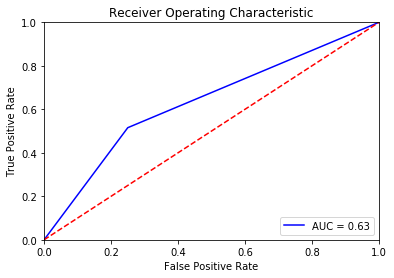

In [33]:
probs = pred_df['Proba'] # predicted probabilities generated by classifier
preds = (probs>0.8) * 1 # predictions 
y_true = pred_df['y_frequency']

plot_roc_auc(preds, y_true)

## Generate and draw decision tree to explain a model

<http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html>

In [49]:

dtree = tree.DecisionTreeClassifier(criterion='gini', splitter='best'
        , max_depth=6, min_samples_split=5, min_samples_leaf=10, min_weight_fraction_leaf=0.0
        , max_features=None, random_state=None, max_leaf_nodes=30, min_impurity_decrease=0.0
        , min_impurity_split=None, class_weight=None, presort=False)
dtree.fit(x_test, preds)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=30,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

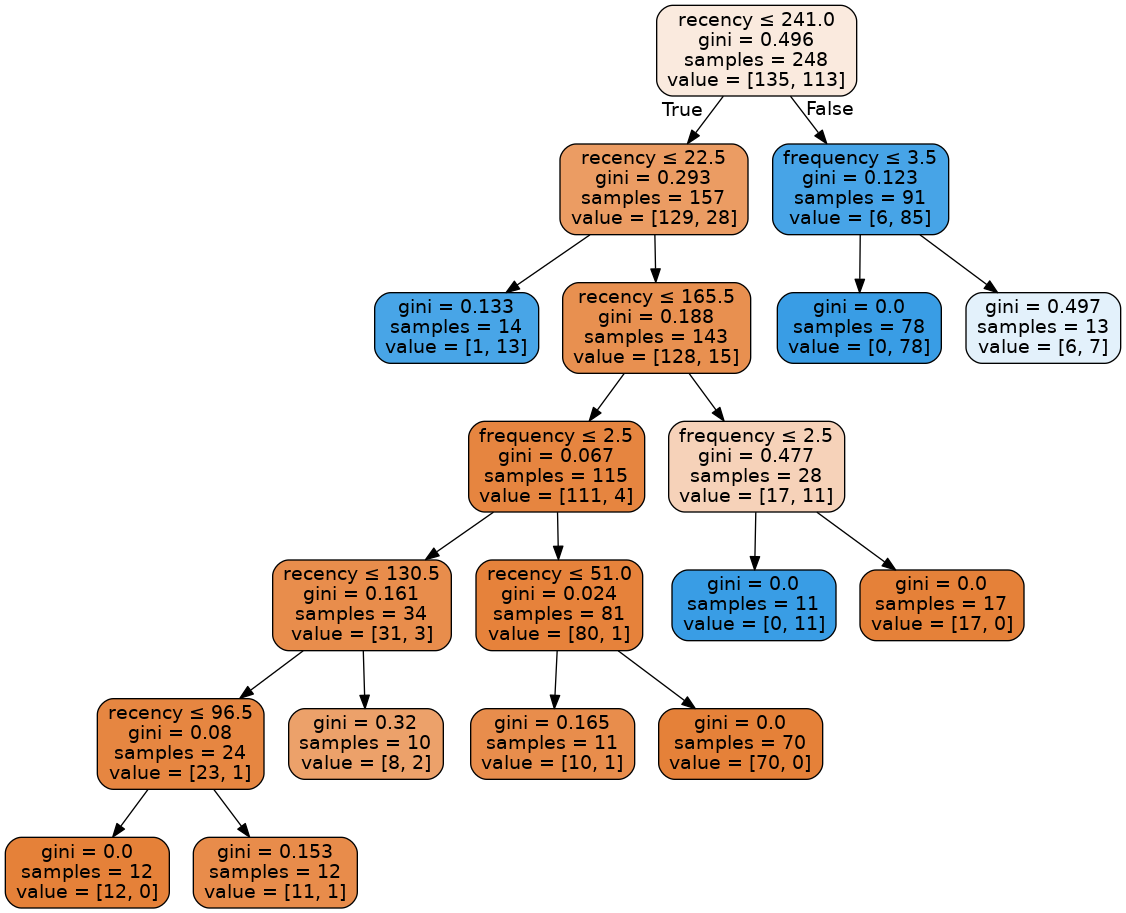

In [50]:
dot_data = StringIO()

export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=x_train.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

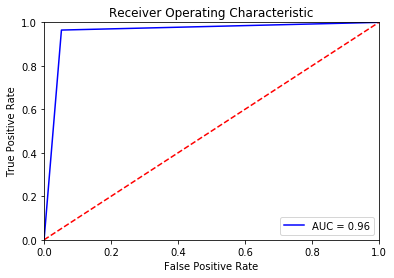

In [51]:
plot_roc_auc(dtree.predict(x_test), preds)